In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [6]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [7]:
# hyperparameters
N = 3
k = 3
tau = 1.

In [8]:
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -Variable(torch.log(-torch.log(U + eps) + eps))

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [9]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, N*k)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        l = h3.view(-1,k)
        return l

In [10]:
def prob(l):
    return F.softmax(l, dim=-1).view(-1, N, k)

def samp(l):
    return gumbel_softmax(l, tau).view(-1, N*k)

In [11]:
class decoder(nn.Module):  
    def __init__(self):
        super(decoder, self).__init__()
        self.fc1 = nn.Linear(N*k, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        o = h3.view(-1,784)
        return F.sigmoid(o)

In [12]:
E = encoder()
D = decoder()

In [13]:
# objective
def loss_function(recon_x, x, q):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
    KLD = torch.sum(q*(torch.log(q+1E-20)-np.log(1/k)))

    return BCE + KLD

In [15]:
# training
epochs = 25
optimizer = optim.Adam([
                {'params':E.parameters()},
                {'params': D.parameters()}
            ], lr=1e-3)

train_loss = 0
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        x = data.view(-1,784)
        optimizer.zero_grad()
        logits = E.forward(x)
        recon_x = D.forward(samp(logits))
        loss = loss_function(recon_x, x, prob(logits))
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))
            

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch+1, train_loss / len(train_loader.dataset)))

    


Train Epoch: 1 [0/60000 (0%)]	Loss: 183.522949
Train Epoch: 1 [20000/60000 (33%)]	Loss: 176.453086
Train Epoch: 1 [40000/60000 (67%)]	Loss: 173.131680
====> Epoch: 1 Average loss: 183.6313
Train Epoch: 2 [0/60000 (0%)]	Loss: 184.438086
Train Epoch: 2 [20000/60000 (33%)]	Loss: 184.485645
Train Epoch: 2 [40000/60000 (67%)]	Loss: 191.842363
====> Epoch: 2 Average loss: 367.2229
Train Epoch: 3 [0/60000 (0%)]	Loss: 186.133496
Train Epoch: 3 [20000/60000 (33%)]	Loss: 182.550742
Train Epoch: 3 [40000/60000 (67%)]	Loss: 178.461934
====> Epoch: 3 Average loss: 551.1805
Train Epoch: 4 [0/60000 (0%)]	Loss: 175.050332
Train Epoch: 4 [20000/60000 (33%)]	Loss: 175.930000
Train Epoch: 4 [40000/60000 (67%)]	Loss: 185.011641
====> Epoch: 4 Average loss: 735.3966
Train Epoch: 5 [0/60000 (0%)]	Loss: 179.744766
Train Epoch: 5 [20000/60000 (33%)]	Loss: 179.746738
Train Epoch: 5 [40000/60000 (67%)]	Loss: 182.776484
====> Epoch: 5 Average loss: 919.5808
Train Epoch: 6 [0/60000 (0%)]	Loss: 183.487930
Train Ep

KeyboardInterrupt: 

In [16]:
test_set = dset.MNIST('data', train=False, download=True, transform=data_transforms)

In [32]:
a = np.array([[[1., 0., 0.],
               [0., 1., 0.],
               [0., 0., 1.]]])

w = D.forward(Variable(torch.from_numpy(a).view(-1,N*k).type(torch.FloatTensor)))
    

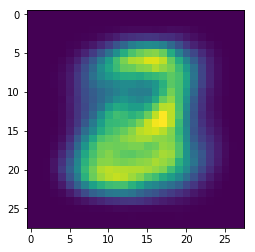

In [33]:
plt.imshow(w.view(28,28).data.numpy())

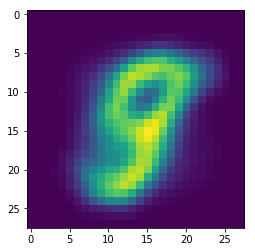

In [35]:
a = np.array([[[1., 0., 0.],
               [0., 1., 0.],
               [0., 1., 0.]]])

w = D.forward(Variable(torch.from_numpy(a).view(-1,N*k).type(torch.FloatTensor)))
plt.imshow(w.view(28,28).data.numpy())

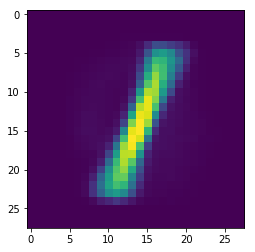

In [43]:
a = np.array([[[1., 0., 0.],
               [0., 0., 1.],
               [1., 0., 0.]]])

w = D.forward(Variable(torch.from_numpy(a).view(-1,N*k).type(torch.FloatTensor)))
plt.imshow(w.view(28,28).data.numpy())